### Import Necessary Libraries

In [31]:
import glob
import pandas as pd
import os
from thefuzz import fuzz, process
import matplotlib.pyplot as plt
import numpy as np
import re

### Merge all CSV

In [32]:
# Set path to your Desktop/Company_info folder
folder_path = "/Users/jackbaek/Desktop/Company_info"  

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Check if any CSV files exist
if not csv_files:
    print("No CSV files found in the specified folder.")
else:
    print(f"Found {len(csv_files)} CSV files. Merging...")
    df_list = []
    
    for file in csv_files:
        try:
            # Read each CSV file
            df = pd.read_csv(file)
            df_list.append(df)
            print(f"Added: {os.path.basename(file)}")
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")
    
    if df_list:
        merged_df = pd.concat(df_list, ignore_index=True)
        output_path = os.path.join(folder_path, "merged_company_info.csv")
        merged_df.to_csv(output_path, index=False)
        print(f"Success! Merged data saved to: {output_path}")
    else:
        print("No valid CSV data to merge.")

Found 11 CSV files. Merging...
Added: company_info_2019.csv
Added: company_info_2025.csv
Added: company_info_2024.csv
Added: company_info_2020.csv
Added: company_info_2021.csv
Added: company_info_2023.csv
Added: company_info_2022.csv
Added: company_info_raw2.csv
Added: company_info_raw3.csv
Added: company_info_raw1.csv
Added: merged_company_info.csv
Success! Merged data saved to: /Users/jackbaek/Desktop/Company_info/merged_company_info.csv


### Fuzzymatching to match unlisted firms

In [33]:
# Load data
csv_path = '/Users/jackbaek/Desktop/Company_info/merged_company_info.csv'
df = pd.read_csv(csv_path)

# Separate listed and unlisted firms
listed = df[df['Ticker'].notnull() & (df['Ticker'] != '')]
unlisted = df[df['Ticker'].isnull() | (df['Ticker'] == '')]

# Unique listed firms by Ticker
unique_listed = set(listed['Ticker'].unique())
print(f"Unique listed firms (by Ticker): {len(unique_listed)}")

# For unlisted firms: fuzzy match company names
unlisted_names = unlisted['Company Name'].dropna().unique()
matched_names = set()
used = set()
threshold = 95  # Adjust as needed (0-100)

print(f"Unlisted company names to process: {len(unlisted_names)}")

# Use token_set_ratio for better name matching
for i, name in enumerate(unlisted_names):
    if name in used:
        continue
        
    # Find matches using token set ratio (better for company names)
    matches = process.extract(
        name, 
        unlisted_names, 
        scorer=fuzz.token_set_ratio,  
        limit=None
    )
    
    # Group similar names
    similar = {match for match, score in matches if score >= threshold}
    matched_names.add(tuple(sorted(similar)))  
    
    # Mark all similar names as processed
    used.update(similar)

# Total unique firms
total_unique_firms = len(unique_listed) + len(matched_names)

print("\nResults:")
print(f"- Unique listed firms: {len(unique_listed)}")
print(f"- Unique unlisted firm groups: {len(matched_names)}")
print(f"Total unique firms: {total_unique_firms}")

Unique listed firms (by Ticker): 5295
Unlisted company names to process: 2882

Results:
- Unique listed firms: 5295
- Unique unlisted firm groups: 2658
Total unique firms: 7953


### How many earnings call transcripts are there?

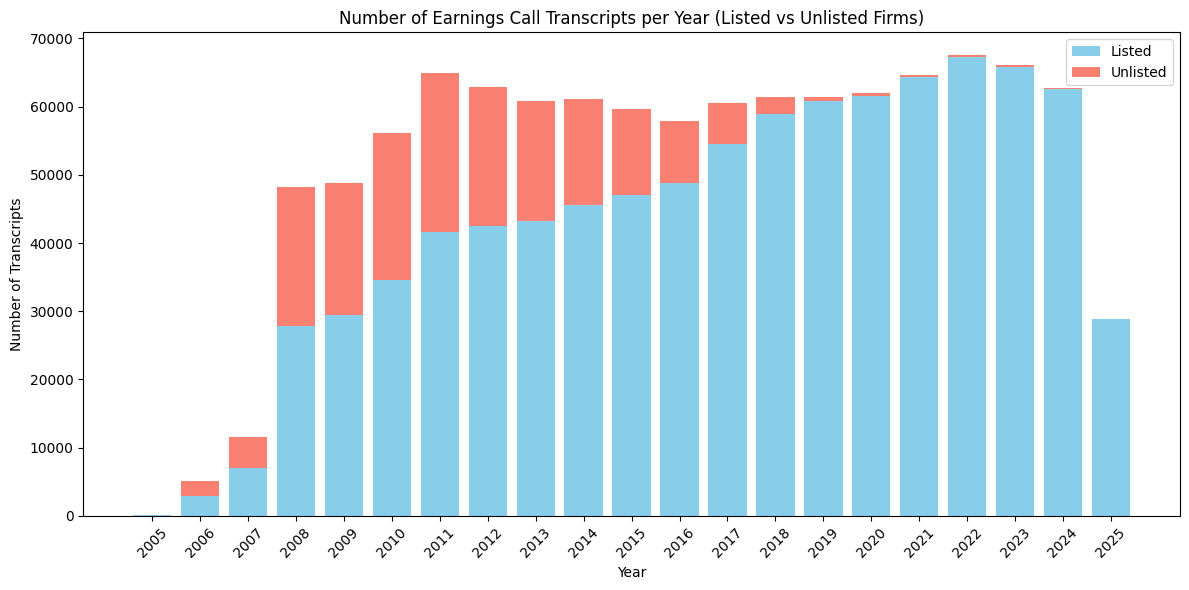

In [34]:
# Parse the year from the 'Date' column

df['Year'] = pd.to_datetime(df['Date'], format='%A, %B %d, %Y', errors='coerce').dt.year

# Create a 'Listed' flag: True if Exchange is not null/empty, else False
df['Listed'] = df['Exchange'].notnull() & (df['Exchange'] != '')

# Count transcripts per year for listed and unlisted firms
counts = df.groupby(['Year', 'Listed']).size().unstack(fill_value=0)

# Sort years for plotting
counts = counts.sort_index()

# Plot stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts[True], label='Listed', color='skyblue')
plt.bar(counts.index, counts[False], bottom=counts[True], label='Unlisted', color='salmon')
plt.xlabel('Year')
plt.ylabel('Number of Transcripts')
plt.title('Number of Earnings Call Transcripts per Year (Listed vs Unlisted Firms)')
plt.xticks(counts.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### How long do companies have transcripts for?

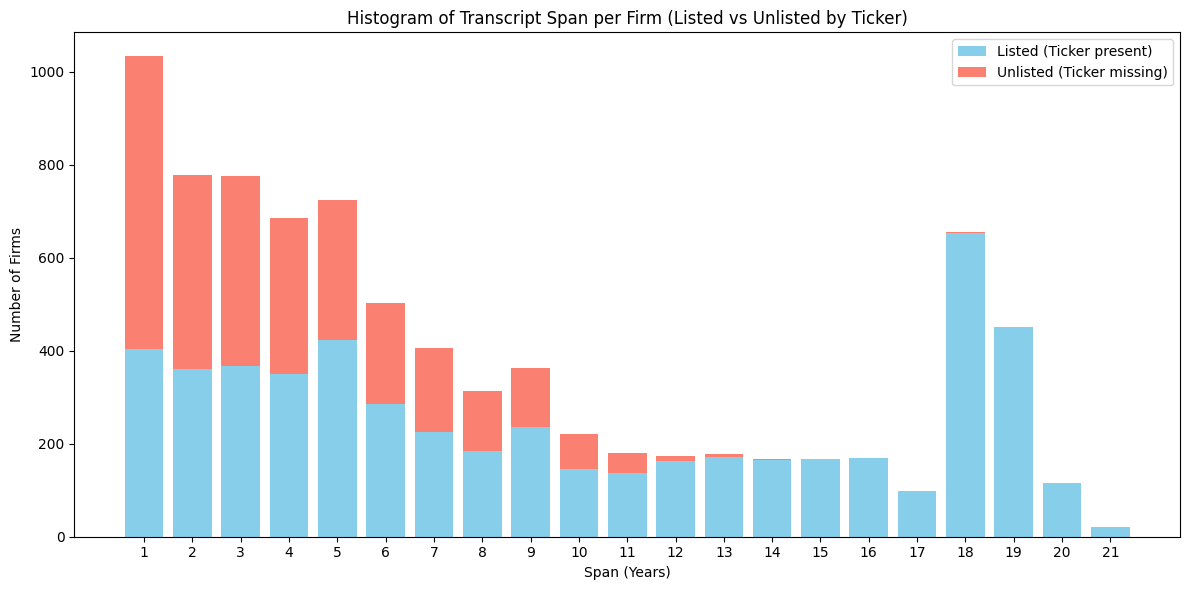

In [35]:
# Clean company names for matching
df['Company Name Clean'] = df['Company Name'].str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True).str.strip()

# Now, create your Firm_ID and Listed flag as before
df['Firm_ID'] = df['Ticker'].fillna('')
df.loc[df['Firm_ID'] == '', 'Firm_ID'] = df['Company Name']

df['Listed'] = df['Ticker'].notnull() & (df['Ticker'] != '')

# Parse year from date
df['Year'] = pd.to_datetime(df['Date'], format='%A, %B %d, %Y', errors='coerce').dt.year
# Calculate span per firm
span_df = df.groupby(['Firm_ID', 'Listed'])['Year'].agg(['min', 'max']).reset_index()
span_df['Span (Years)'] = span_df['max'] - span_df['min'] + 1

# Prepare data for stacked histogram
listed_span = span_df[span_df['Listed']]['Span (Years)']
unlisted_span = span_df[~span_df['Listed']]['Span (Years)']

# Define bins
max_span = span_df['Span (Years)'].max()
bins = range(1, max_span + 2)

# Calculate histogram values
listed_hist, _ = np.histogram(listed_span, bins=bins)
unlisted_hist, _ = np.histogram(unlisted_span, bins=bins)

# Plot stacked histogram
plt.figure(figsize=(12, 6))
plt.bar(
    bins[:-1],
    listed_hist,
    label='Listed (Ticker present)',
    color='skyblue',
    align='center',
    width=0.8
)
plt.bar(
    bins[:-1],
    unlisted_hist,
    bottom=listed_hist,
    label='Unlisted (Ticker missing)',
    color='salmon',
    align='center',
    width=0.8
)
plt.xlabel('Span (Years)')
plt.ylabel('Number of Firms')
plt.title('Histogram of Transcript Span per Firm (Listed vs Unlisted by Ticker)')
plt.xticks(bins[:-1])
plt.legend()
plt.tight_layout()
plt.show()

### Is there a significant difference between total years and continuous years?

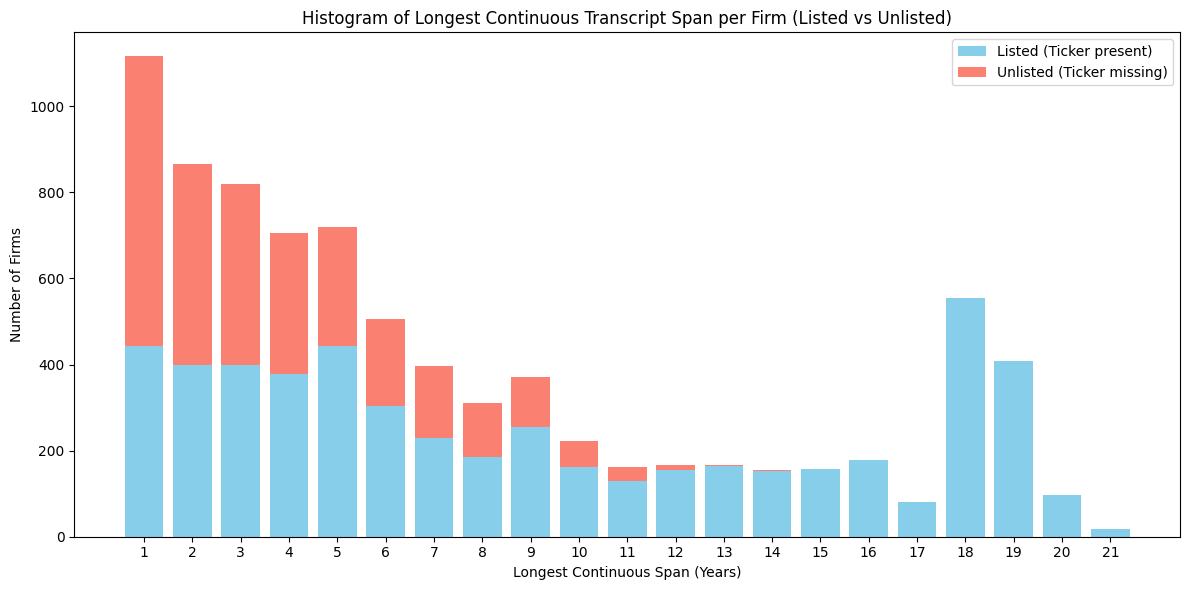

In [36]:
# Filter out rows with missing Year or Firm_ID
filtered_df = df.dropna(subset=['Year', 'Firm_ID'])

# Sort by Firm_ID and Year
filtered_df = filtered_df.sort_values(['Firm_ID', 'Year'])

# Calculate longest continuous span for each firm
span_records = []
for firm, group in filtered_df.groupby('Firm_ID'):
    years = group['Year'].dropna().unique()
    years = np.sort(years)
    if len(years) == 0:
        continue
    # Find all continuous spans
    spans = []
    start = years[0]
    prev = years[0]
    for y in years[1:]:
        if y == prev + 1:
            prev = y
        else:
            spans.append(prev - start + 1)
            start = y
            prev = y
    spans.append(prev - start + 1)  # last span
    longest_span = max(spans)
    is_listed = group['Listed'].iloc[0]
    span_records.append({'Firm_ID': firm, 'Longest_Continuous_Span': longest_span, 'Listed': is_listed})

span_df = pd.DataFrame(span_records)

# Prepare data for stacked histogram
listed_span = span_df[span_df['Listed']]['Longest_Continuous_Span']
unlisted_span = span_df[~span_df['Listed']]['Longest_Continuous_Span']
max_span = span_df['Longest_Continuous_Span'].max()
bins = range(1, max_span + 2)

# Calculate histogram values
listed_hist, _ = np.histogram(listed_span, bins=bins)
unlisted_hist, _ = np.histogram(unlisted_span, bins=bins)

# Plot stacked histogram
plt.figure(figsize=(12, 6))
plt.bar(
    bins[:-1],
    listed_hist,
    label='Listed (Ticker present)',
    color='skyblue',
    align='center',
    width=0.8
)
plt.bar(
    bins[:-1],
    unlisted_hist,
    bottom=listed_hist,
    label='Unlisted (Ticker missing)',
    color='salmon',
    align='center',
    width=0.8
)
plt.xlabel('Longest Continuous Span (Years)')
plt.ylabel('Number of Firms')
plt.title('Histogram of Longest Continuous Transcript Span per Firm (Listed vs Unlisted)')
plt.xticks(bins[:-1])
plt.legend()
plt.tight_layout()
plt.show()

### What is the exchange breakdown of the transcripts?

In [37]:
nyse_list = ['NYSE']
nasdaq_list = ['NASDAQ', 'NasdaqCM', 'NasdaqGM', 'NasdaqGS']
other_american_list = [
    'AMEX', 'NYSEAM', 'BATS', 'IEX', 'ISE', 'OB', 'OTCPK', 'MutualFund'
]
foreign_list = [
    'AIM', 'ASX', 'BOVESPA', 'CNSX', 'ENXTAM', 'ENXTPA', 'JSE', 'LSE', 'NEOE',
    'NZSE', 'OM', 'SEHK', 'TSX', 'TSXV', 'WSE'
]

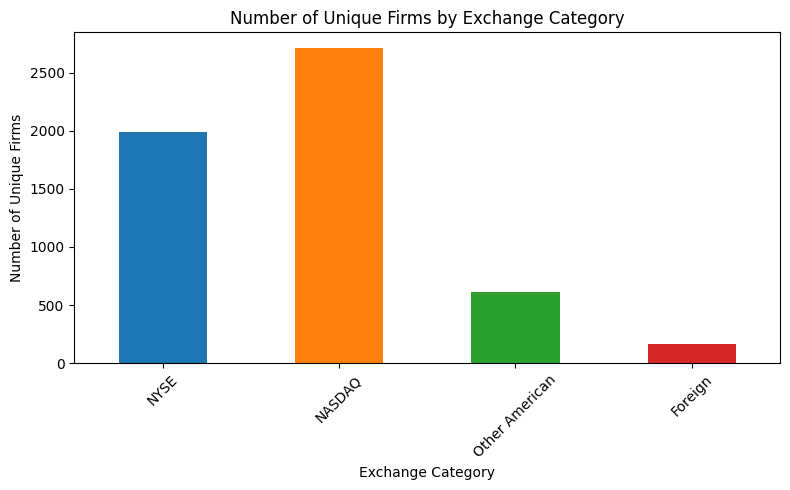

Unique firms per exchange category:
NYSE: 1989
NASDAQ: 2711
Other American: 616
Foreign: 161


In [38]:
# Define exchange categories
nyse_list = ['NYSE']
nasdaq_list = ['NASDAQ', 'NasdaqCM', 'NasdaqGM', 'NasdaqGS']
other_american_list = [
    'AMEX', 'NYSEAM', 'BATS', 'IEX', 'ISE', 'OB', 'OTCPK', 'MutualFund'
]
foreign_list = [
    'AIM', 'ASX', 'BOVESPA', 'CNSX', 'ENXTAM', 'ENXTPA', 'JSE', 'LSE', 'NEOE',
    'NZSE', 'OM', 'SEHK', 'TSX', 'TSXV', 'WSE'
]

# Filter out rows where Exchange is empty or null
df_with_exchange = df[df['Exchange'].notnull() & (df['Exchange'] != '')].copy()

# Classify exchanges
def classify_exchange(exchange):
    exchange_upper = str(exchange).upper()
    if exchange_upper in [e.upper() for e in nyse_list]:
        return 'NYSE'
    elif exchange_upper in [e.upper() for e in nasdaq_list]:
        return 'NASDAQ'
    elif exchange_upper in [e.upper() for e in other_american_list]:
        return 'Other American'
    elif exchange_upper in [e.upper() for e in foreign_list]:
        return 'Foreign'
    else:
        return 'Foreign'

df_with_exchange['Exchange_Category'] = df_with_exchange['Exchange'].apply(classify_exchange)

# Count unique firms per category
unique_firms_per_category = df_with_exchange.groupby('Exchange_Category')['Firm_ID'].nunique().reindex(
    ['NYSE', 'NASDAQ', 'Other American', 'Foreign'], fill_value=0
)

# Plot histogram
plt.figure(figsize=(8, 5))
unique_firms_per_category.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Number of Unique Firms by Exchange Category')
plt.xlabel('Exchange Category')
plt.ylabel('Number of Unique Firms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the counts
print("Unique firms per exchange category:")
for category, count in unique_firms_per_category.items():
    print(f"{category}: {count}")


### How long do companeis have transcripts for in fiscal quarters?

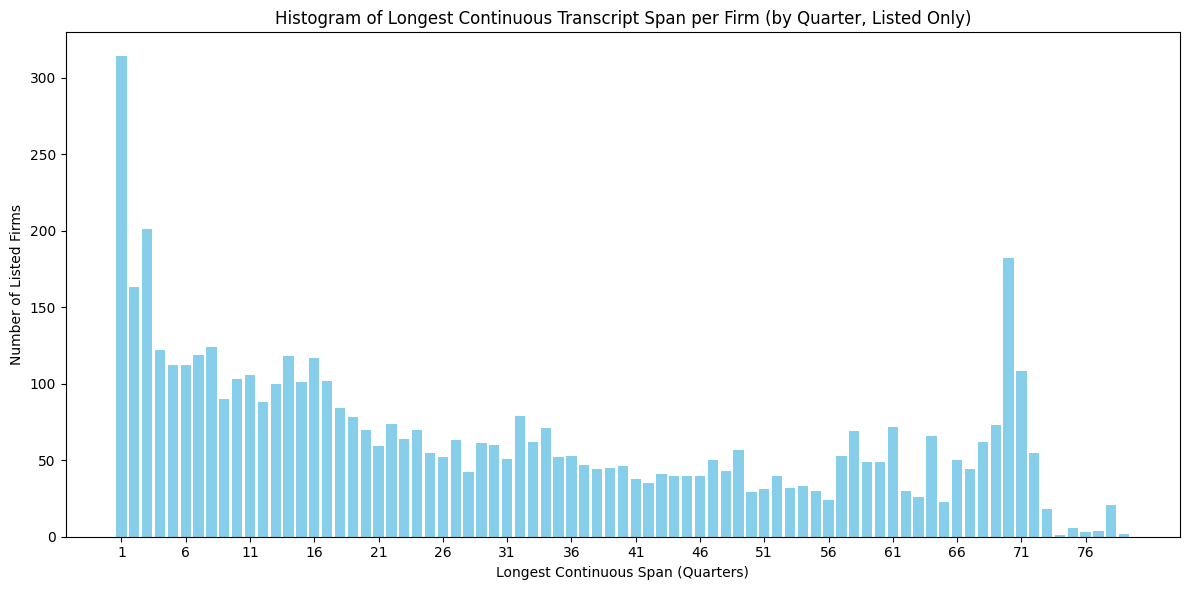

In [39]:
# Extract Year and Quarter from Filename
def extract_year_quarter(filename):
    match = re.search(r'Q([1-4])\s*(\d{4})', str(filename))
    if match:
        return int(match.group(2)), int(match.group(1))
    return np.nan, np.nan

df[['Year', 'Quarter']] = df['Filename'].apply(lambda x: pd.Series(extract_year_quarter(x)))

# Filter for listed firms and drop rows with missing Year, Quarter, or Firm_ID
filtered_df = df[df['Listed'] & df['Year'].notnull() & df['Quarter'].notnull() & df['Firm_ID'].notnull()].copy()

# Create a unique sequential quarter index for each row
filtered_df['Year'] = filtered_df['Year'].astype(int)
filtered_df['Quarter'] = filtered_df['Quarter'].astype(int)
filtered_df['Quarter_Index'] = filtered_df['Year'] * 4 + filtered_df['Quarter']

# Sort by Firm_ID and Quarter_Index
filtered_df = filtered_df.sort_values(['Firm_ID', 'Quarter_Index'])

# Calculate longest continuous span of quarters for each firm
span_records = []
for firm, group in filtered_df.groupby('Firm_ID'):
    quarters = group['Quarter_Index'].dropna().unique()
    quarters = np.sort(quarters)
    if len(quarters) == 0:
        continue
    # Find all continuous spans
    spans = []
    start = quarters[0]
    prev = quarters[0]
    for q in quarters[1:]:
        if q == prev + 1:
            prev = q
        else:
            spans.append(prev - start + 1)
            start = q
            prev = q
    spans.append(prev - start + 1)  # last span
    longest_span = max(spans)
    span_records.append({'Firm_ID': firm, 'Longest_Continuous_Quarter_Span': longest_span})

span_df = pd.DataFrame(span_records)

# Prepare data for histogram
max_span = span_df['Longest_Continuous_Quarter_Span'].max()
bins = range(1, max_span + 2)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(
    span_df['Longest_Continuous_Quarter_Span'],
    bins=bins,
    align='left',
    rwidth=0.8,
    color='skyblue'
)
plt.xlabel('Longest Continuous Span (Quarters)')
plt.ylabel('Number of Listed Firms')
plt.title('Histogram of Longest Continuous Transcript Span per Firm (by Quarter, Listed Only)')
step =5
xticks = np.arange(1, max_span + 1, step)
plt.xticks(xticks)
plt.tight_layout()
plt.show()

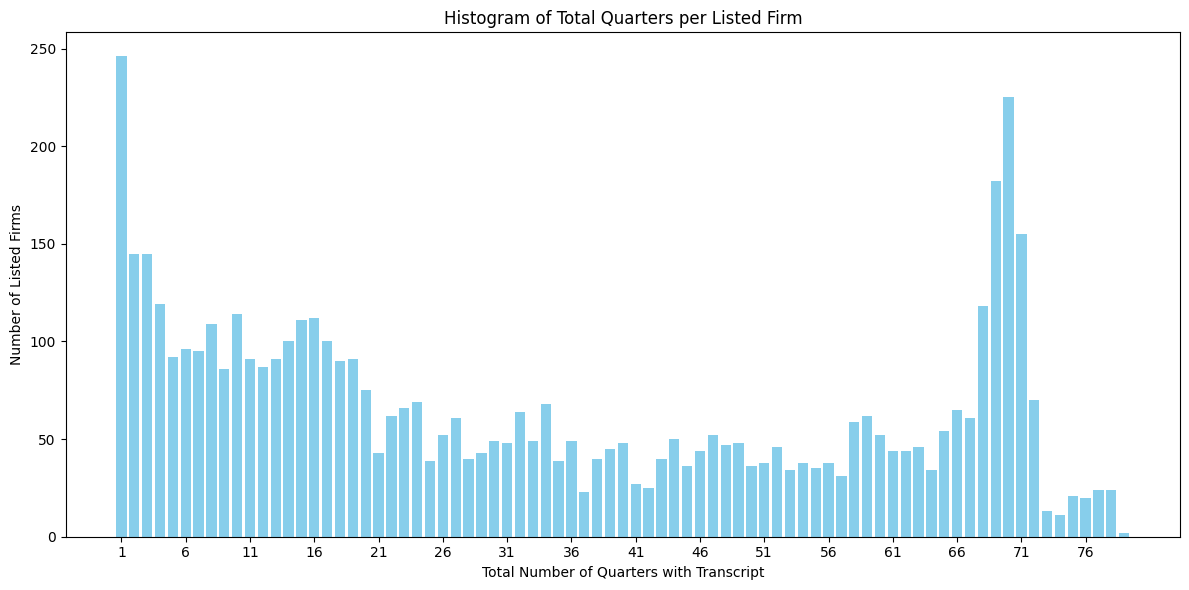

In [40]:
# Filter for listed firms and valid quarters/years
listed_df = df[df['Listed'] & df['Year'].notnull() & df['Quarter'].notnull() & df['Firm_ID'].notnull()].copy()

# Count total unique quarters per firm
listed_df['Year'] = listed_df['Year'].astype(int)
listed_df['Quarter'] = listed_df['Quarter'].astype(int)
listed_df['Quarter_ID'] = listed_df['Year'].astype(str) + 'Q' + listed_df['Quarter'].astype(str)

quarter_counts = listed_df.groupby('Firm_ID')['Quarter_ID'].nunique().reset_index(name='Total_Quarters')

# Plot histogram
max_quarters = quarter_counts['Total_Quarters'].max()
bins = range(1, max_quarters + 2)

plt.figure(figsize=(12, 6))
plt.hist(
    quarter_counts['Total_Quarters'],
    bins=bins,
    align='left',
    rwidth=0.8,
    color='skyblue'
)
plt.xlabel('Total Number of Quarters with Transcript')
plt.ylabel('Number of Listed Firms')
plt.title('Histogram of Total Quarters per Listed Firm')

# Show only every 5th or 10th x-tick
step = 5  # or 10 for even fewer ticks
xticks = np.arange(1, max_quarters + 1, step)
plt.xticks(xticks)
plt.tight_layout()
plt.show()
